# Machine Learning Essentials SS25 - Exercise Sheet 6

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as tc
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

np.random.seed(42)
tc.manual_seed(42)

device = tc.device("cuda" if tc.cuda.is_available() else "cpu")

## Exercise 2 - CNN Classifier

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5. We first load the data and have the shapes printed out. The split into train, validation and test set has already been carried out.

In [8]:
# Load the dataset
X_train = np.load('sign_data/X_train.npy')
Y_train = np.load('sign_data/Y_train.npy')
X_val = np.load('sign_data/X_val.npy')
Y_val = np.load('sign_data/Y_val.npy')
X_test = np.load('sign_data/X_test.npy')
Y_test = np.load('sign_data/Y_test.npy')

# print the shape of the dataset
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("Y_val shape: " + str(Y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape)+"\n")
print("classes: " + str(np.unique(Y_train)))

# check if classes are balanced
print("Counts of classes in Y_train: " + str(np.unique(Y_train, return_counts=True)[1]))
print("Counts of classes in Y_val: " + str(np.unique(Y_val, return_counts=True)[1]))
print("Counts of classes in Y_test: " + str(np.unique(Y_test, return_counts=True)[1]))

X_train shape: (960, 64, 64, 3)
Y_train shape: (960,)
X_val shape: (120, 64, 64, 3)
Y_val shape: (120,)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120,)

classes: [0 1 2 3 4 5]
Counts of classes in Y_train: [160 160 160 160 160 160]
Counts of classes in Y_val: [20 20 20 20 20 20]
Counts of classes in Y_test: [20 20 20 20 20 20]


The classes are balanced so that accuracy is an appropriate measure for evaluating a classifier. We next visualize an instance of each class.

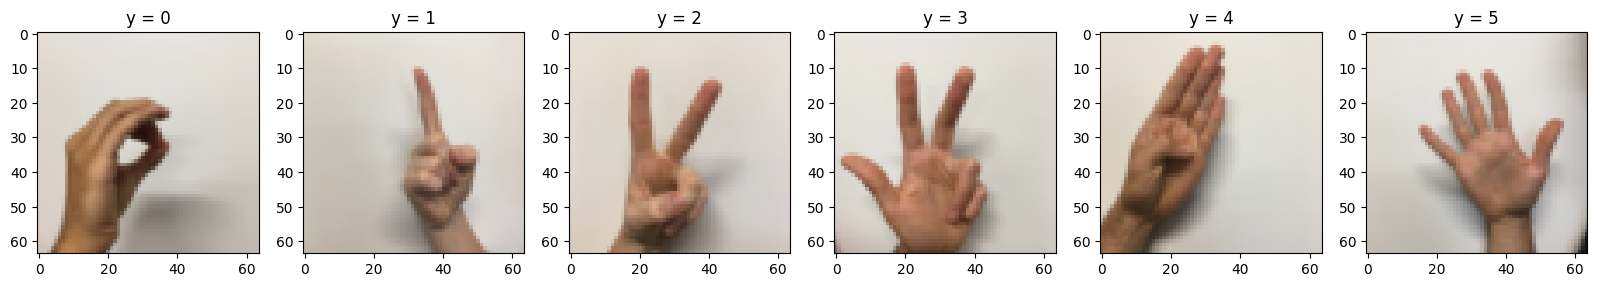

In [9]:
fig, axs = plt.subplots(1, 6, figsize=(20, 10))
for i in range(6):
    # get indices where the label is i
    idx = np.where(Y_train == i)[0][0]
    axs[i].imshow(X_train[idx])
    axs[i].set_title("y = " + str(i))

Pixels in each channel (RGB) of the images take values in the range \[0, 255\]. However, it is desirable to have absolute values in the range \[0, 1\] as input for neural network architectures to avoid exploding or vanishing gradient problems. Through the following cell, we apply a simple data scaling procedure: we divide the values of the pixels by 255.
As an alternative, you can use the `StandardScaler()` function of the scikit-learn library.

In [10]:
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [13]:
X_train[0].shape

(64, 64, 3)

### Task 1

Use pytorch to build the model. Take a look at the [documentation](https://pytorch.org/tutorials/beginner/basics/intro.html) for an introduction, a detailed tutorial, for example for classifiers, can be found [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

Implement the following architecture:

     - Conv2d: 4 output channels, 3 by 3 filter size, stride 1, padding "same"
     - BatchNorm2d: 4 output channels
     - ReLU activation
     - MaxPool2d: 2 by 2 filter size, stride 2, padding 0
     - Conv2d: 8 output channels, 3 by 3 filter size, stride 1, padding "same"
     - BatchNorm2d: 8 output channels
     - ReLU activation
     - MaxPool2d: Use a 2 by 2 filter size, stride 2, padding 0
     - Flatten the previous output
     - Linear: 64 output neurons
     - ReLu activation function
     - Linear: 6 output neurons
     - LogSoftmax

We use the [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) here instead of the Softmax for computational reasons. Accordingly, the loss function is not CrossEntropyLoss but NLLLoss. When flattening, be careful not to do it with the batch dimension but only with the height, width and channel dimension.

In [92]:
class CNN_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_conv = nn.Sequential(
            nn.Conv2d(3, 4, (3, 3), 1, "same"),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        # output dim 32 [(64-2)/2 + 1]

        self.second_conv = nn.Sequential(
            nn.Conv2d(4, 8, (3,3), 1, "same"),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        # output dim = 16 [(32 - 2)/2 + 1]

        self.lin_layer = nn.Sequential(
            nn.Flatten(),
            # output dim = 16 * 16 * 8 = 2048
            nn.Linear(2048, 64),
            nn.ReLU(),
            nn.Linear(64, 6)
        )
    
    def forward(self, X):
        # TODO: Implement the forward pass
        X = self.first_conv(X)
        X = self.second_conv(X)
        X = self.lin_layer(X)
        return nn.LogSoftmax(dim=1)(X)

To test your model you can foward some random numbers. The shape of the output should be (2, 6).

In [93]:
cnn_model = CNN_Classifier()
# dummy sample of batch size 2
X_random = tc.randn(2, 3, 64, 64)
output = cnn_model(X_random)

print("Output shape: " + str(output.shape))

Output shape: torch.Size([2, 6])


torchsummary.summary provides a nice overview of the model and the number of learnable parameters:

In [94]:
summary(cnn_model, input_size=(3, 64, 64), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 64, 64]             112
       BatchNorm2d-2            [-1, 4, 64, 64]               8
              ReLU-3            [-1, 4, 64, 64]               0
         MaxPool2d-4            [-1, 4, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             296
       BatchNorm2d-6            [-1, 8, 32, 32]              16
              ReLU-7            [-1, 8, 32, 32]               0
         MaxPool2d-8            [-1, 8, 16, 16]               0
           Flatten-9                 [-1, 2048]               0
           Linear-10                   [-1, 64]         131,136
             ReLU-11                   [-1, 64]               0
           Linear-12                    [-1, 6]             390
Total params: 131,958
Trainable params: 131,958
Non-trainable params: 0
-------------------------------

### Task 2

DataLoaders wrap around Datasets to provide efficient data batching, shuffling, and parallel loading during model training or inference. To define a custom dataset we must implement three functions: __init__, __len__ and __get_item__. While __len__ defines the length of the dataset and thus the number of batches in the dataloader, __get_item__ can be used to get a single sample through the index.

In [95]:
class Image_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        # TODO: Return the length of the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # TODO: Return the image as a float tensor and the label as a long tensor
        img = self.X[idx]
        label = np.array(self.Y[idx])
        img = tc.from_numpy(img).float()
        
        #print(label.size())

        # permute the shape to (3, 64, 64)
        img = img.permute(2, 0, 1)
        label = tc.from_numpy(label).long()
        return img, label


In [97]:
train_batch_size = 64
val_batch_size = len(Y_val)
test_batch_size = len(Y_test)

# TODO: Create the dataset and dataloader
train_dataset = Image_Dataset(X_train, Y_train)
val_dataset = Image_Dataset(X_val, Y_val)
test_dataset = Image_Dataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, test_batch_size, shuffle=True)

To make sure that everything has worked properly, we take a sample of the data_loader and visualize it.

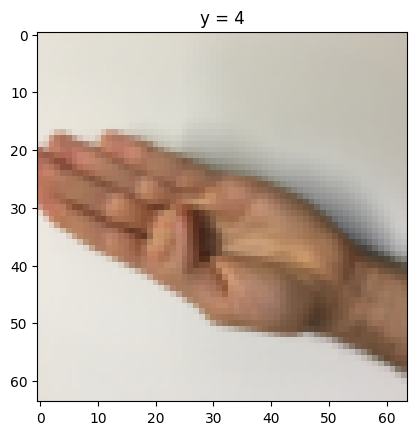

In [98]:
sample_X, sample_Y = next(iter(train_loader))
plt.imshow(sample_X[0].T)
plt.title("y = " + str(int(sample_Y[0].item())))
plt.show()

### Task 3

Implement the training loop. Use the negative log-likelihood loss (NLLLoss) and the Adam optimizer. Be sure to zero the gradients after each optimization step to avoid accumulating contributions from previous epochs and batches.

In [103]:
def train_cnn(model, train_loader, val_loader, lr, n_epochs, device):
    model = model.to(device)

    # TODO: Initialize the optimizer and loss function
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = np.zeros(n_epochs)
    val_loss = np.zeros(n_epochs)
    train_acc = np.zeros(n_epochs)
    val_acc = np.zeros(n_epochs)

    for epoch in range(1, n_epochs + 1):
        model.train()

        epoch_loss = 0

        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            # TODO: Implement the training loop

            optimizer.zero_grad()

            output = model(X)

            loss = loss_function(output, Y)

            loss.backward()

            optimizer.step()


            epoch_loss += loss.item()/len(train_loader)
        
        train_loss[epoch - 1] = epoch_loss
        train_acc[epoch - 1] = (output.argmax(dim=1) == Y).float().mean().item()
        
        model.eval()

        with tc.no_grad():
            X, Y = next(iter(val_loader))
            X, Y = X.to(device), Y.to(device)
            # TODO: Implement the evaluation step
            output = model(X)
            loss = loss_function(output, Y)
                  
            val_loss[epoch - 1] = loss.item()
            val_acc[epoch - 1] = (output.argmax(dim=1) == Y).float().mean().item()
        print(f"Epoch {epoch}/{n_epochs} - Train Loss: {epoch_loss:.4f}, Test Loss: {loss.item():.4f}")

    return train_loss, val_loss, train_acc, val_acc

In [110]:
n_epochs = 50
# TODO: Train the model with different learning rates
learning_rates = [0.0001, 0.001, 0.01, 0.1]
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

models = [CNN_Classifier() for _ in learning_rates]
for lr in learning_rates:
    model = models[learning_rates.index(lr)]
    train_loss, val_loss, train_acc, val_acc = train_cnn(model, train_loader, val_loader, lr, n_epochs, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


Epoch 1/50 - Train Loss: 1.7269, Test Loss: 1.7896
Epoch 2/50 - Train Loss: 1.5451, Test Loss: 1.7716
Epoch 3/50 - Train Loss: 1.3725, Test Loss: 1.5698
Epoch 4/50 - Train Loss: 1.2128, Test Loss: 1.2905
Epoch 5/50 - Train Loss: 1.0689, Test Loss: 1.1080
Epoch 6/50 - Train Loss: 0.9419, Test Loss: 0.9817
Epoch 7/50 - Train Loss: 0.8375, Test Loss: 0.9009
Epoch 8/50 - Train Loss: 0.7547, Test Loss: 0.8321
Epoch 9/50 - Train Loss: 0.6829, Test Loss: 0.7824
Epoch 10/50 - Train Loss: 0.6202, Test Loss: 0.7332
Epoch 11/50 - Train Loss: 0.5714, Test Loss: 0.7033
Epoch 12/50 - Train Loss: 0.5327, Test Loss: 0.6748
Epoch 13/50 - Train Loss: 0.4953, Test Loss: 0.6325
Epoch 14/50 - Train Loss: 0.4625, Test Loss: 0.6227
Epoch 15/50 - Train Loss: 0.4302, Test Loss: 0.5981
Epoch 16/50 - Train Loss: 0.4042, Test Loss: 0.5777
Epoch 17/50 - Train Loss: 0.3792, Test Loss: 0.5559
Epoch 18/50 - Train Loss: 0.3583, Test Loss: 0.5410
Epoch 19/50 - Train Loss: 0.3406, Test Loss: 0.5321
Epoch 20/50 - Train L

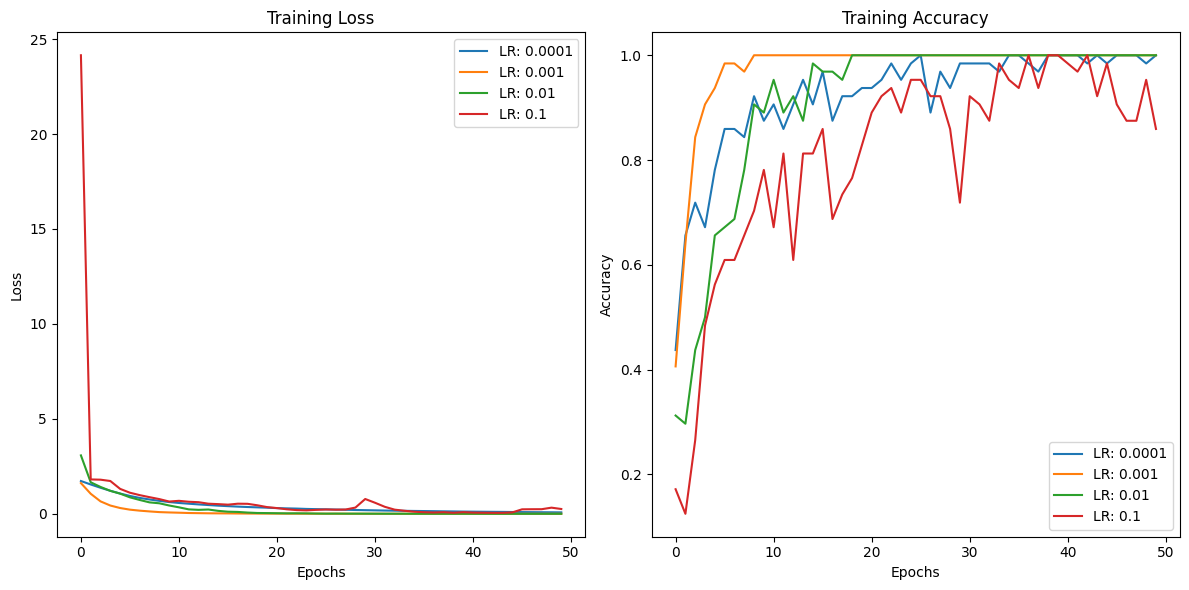

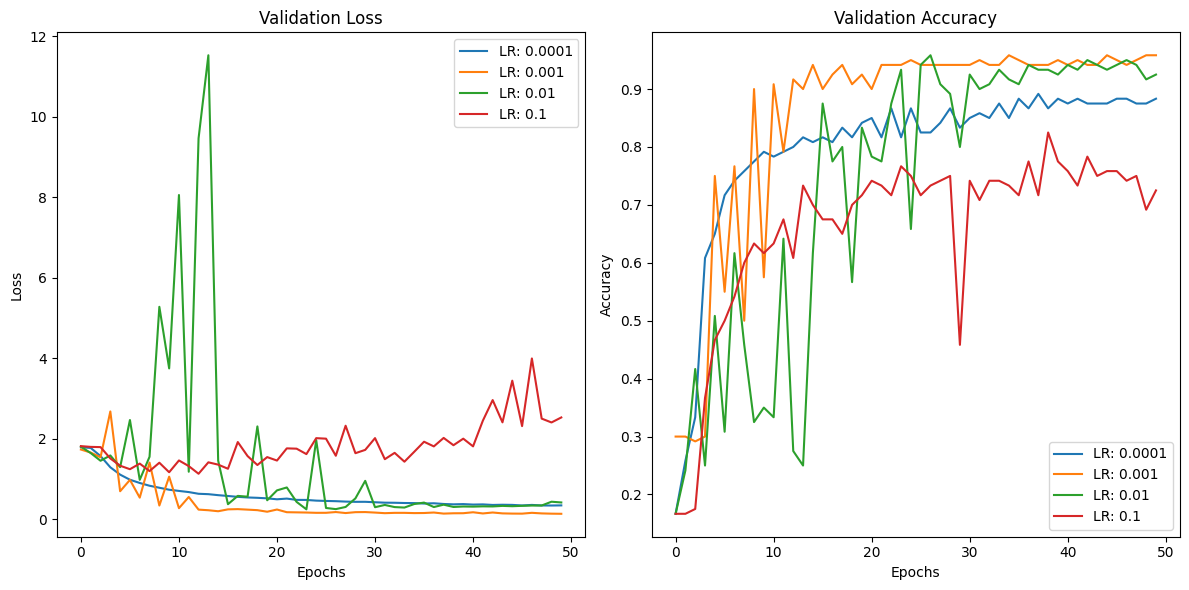

In [111]:
# TODO: Visualize the results
# Training loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
for i, lr in enumerate(learning_rates):
    plt.plot(train_losses[i], label=f"LR: {lr}")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
for i, lr in enumerate(learning_rates):
    plt.plot(train_accuracies[i], label=f"LR: {lr}")
plt.legend()
plt.tight_layout()
plt.show()


# Validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
for i, lr in enumerate(learning_rates):
    plt.plot(val_losses[i], label=f"LR: {lr}")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
for i, lr in enumerate(learning_rates):
    plt.plot(val_accuracies[i], label=f"LR: {lr}")
plt.legend()
plt.tight_layout()
plt.show()

### Task 4

In [113]:
# TODO: apply the best model to the test set
# Take the model with LR = 0.001 as best model because it converges the fastest

best_model = models[1]

best_model.eval()
test_loss = 0
test_acc = 0
with tc.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        output = best_model(X)
        loss = nn.NLLLoss()(output, Y)
        test_loss += loss.item() / len(test_loader)
        test_acc += (output.argmax(dim=1) == Y).float().mean().item() / len(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.1655, Test Accuracy: 0.9500


## Exercise 3 -  CNN Autoencoder

In the next task we want to build an autoencoder. It consists of an encoder, which transforms the data into a low-dimensional code, and a decoder, which reconstructs the original data. 

We use the Fashion MNIST dataset, which consists of 28x28 grayscale images. There are 10 classes, each representing different items of clothing. The data can be conveniently downloaded, separated and transformed with torchvision. As we will not be tuning any hyperparameters, we do not need a validation set.

In [ ]:
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor (range [0, 1])
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Load FashionMNIST train and test sets
train_data = datasets.FashionMNIST(
    root='./fashion_mnist',          # Download path
    train=True,            # Load training set
    download=True,         # Download if not already present
    transform=transform    # Apply transformations
)

test_data = datasets.FashionMNIST(
    root='./fashion_mnist',
    train=False,           # Load test set
    download=True,
    transform=transform
)

classes = train_data.targets.unique()

# we only need a subset that consists of 1000 samples of each class for the train set
# and 10 samples of each class for the test set
indices_train = []
indices_test = []
for i in range(len(classes)):
    indices_train += list(np.where(train_data.targets == classes[i])[0][:1000])
    indices_test += list(np.where(test_data.targets == classes[i])[0][:10])
    
train_data.data = train_data.data[indices_train]
train_data.targets = train_data.targets[indices_train]
test_data.data = test_data.data[indices_test]
test_data.targets = test_data.targets[indices_test]

# Create DataLoaders 
train_batch_size = 256
test_batch_size = len(test_data) 
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

# Print the shape of the dataset
print("train images shape: " + str(train_data.data.shape))
print("train labels shape: " + str(train_data.targets.shape))
print("test images shape: " + str(test_data.data.shape))
print("test labels shape: " + str(test_data.targets.shape))
print("classes: " + str(classes))

# check if classes are balanced
print("Counts of classes in train set: " + str(train_data.targets.unique(return_counts=True)[1]))
print("Counts of classes in test set: " + str(test_data.targets.unique(return_counts=True)[1]))

In [ ]:
# Get a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Visualize a batch of images
fig, axes = plt.subplots(4, 10, figsize=(12, 6))
for i in range(4):
    for j in range(10):
        # find the ith image of class j
        idx = np.where(labels == j)[0][i]
        axes[i, j].imshow(images[idx].squeeze(), cmap='gray')
        axes[i, j].set_title(f"Label: {j}")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


### Task 1

We compare two architectures: a linear autoencoder and a CNN autoencoder. The latter typically consists of convolutional layers for the encoder and transposed convolutional layers for the decoder. In addition, fully connected layers can bring the feature to the desired code dimension (also called latent dimension). Implement the following architecture:

Encoder:
- Conv2d: 16 output channels, 3 by 3 filter size, stride 1, padding "same"
- ReLU activation
- MaxPool2d: 2 by 2 filter, stride 1, padding 0
- Conv2d: 32 output channels, 3 by 3, stride 1, padding "same"
- ReLU activation
- MaxPool2d: 2 by 2 filter, stride 1, padding 0
- Conv2d: 64 output channel, 3 by 3 filter size, stride 1, padding "same"
- ReLU activation
- MaxPool2d: 2 by 2 filter, stride 1, padding 0
- Flatten the previous output
- Linear: <_latent dimension_> output neurons

Decoder:
- Linear: 64x3x3 = 576 output neurons
- Unflatten the previous output to shape (64, 3, 3)
- ConvTranspose2d: 32 output channels, 3 by 3 filter size, stride 2, padding 0, output padding 1
- ReLU activation
- ConvTranspose2d: 16 output channels, 3 by 3 filter size, stride 2, padding 1, output padding 1
- ReLU activation
- ConvTranspose2d: 1 output channel, 3 by 3 filter size, stride 2, padding 1, output padding 1

You might need to infer the input dimension of the linear layer in the encoder.

In [ ]:
class Conv_AE(nn.Module):
    def __init__(self, latent_dim):
        super(Conv_AE, self).__init__()

        # TODO: Initialize the layers of the encoder
        self.encoder = nn.Sequential(
        )
        
        # TODO: Initialize the layers of the decoder
        self.decoder = nn.Sequential(
        )
            
    def forward(self, X):
        # TODO: Implement the forward pass


We check again whether the model is working properly.

In [ ]:
conv_ae_model = Conv_AE(2)
X_random = tc.randn(2, 1, 28, 28)
reconstructed, latent = conv_ae_model(X_random)

print("Reconstructed shape: " + str(reconstructed.shape), "\n", "Latent shape: " + str(latent.shape))

summary(conv_ae_model, input_size=(1, 28, 28), device="cpu")

### Task 2

The training of an autoencoder compares the original input to the reconstruction, usually by means of the mean squared error.

In [ ]:
def train_ae(model, train_loader, test_loader, lr, n_epochs, device):
    model = model.to(device)

    # TODO: Initialize the loss function
    loss_function = 
    optimizer = 

    train_loss = np.zeros(n_epochs)
    test_loss = np.zeros(n_epochs)

    for epoch in range(1, n_epochs + 1):
        model.train()

        epoch_loss = 0

        for X, _ in train_loader:
            X = X.to(device)
            # TODO: Implement the training loop

            epoch_loss += loss.item()/len(train_loader)
        
        train_loss[epoch - 1] = epoch_loss
        
        model.eval()

        with tc.no_grad():
            X, _ = next(iter(test_loader))
            X = X.to(device)
            # TODO: Implement the evaluation step

            
            test_loss[epoch - 1] = loss.item()
        print(f"Epoch {epoch}/{n_epochs} - Train Loss: {epoch_loss:.4f}, Test Loss: {loss.item():.4f}")

    return train_loss, test_loss

In [ ]:
n_epochs = 60
lr = 1e-3
# TODO: Train the convolutional autoencoder model with different latent dimensions

In [ ]:
# TODO: Visualize the results


In [ ]:
#TODO: Visualize the reconstructed images and the original images

### Task 3

A linear autoencoder aims to represent the data $X\in \mathbb{R}^{n\times m}$ in a new basis using only $d<m$ directions.
The objective is to minimize the squared error between $X$ and $D(E(X))$ where $E: \mathbb{R}^{m}\to\mathbb{R}^{d}$ is the encoder and $D: \mathbb{R}^{d}\to\mathbb{R}^{m}$ is the decoder:
$$\|D(E(X)) - X\|^2_2$$

In geometric terms, we want to find $d$ axes along which most of the variance occurs which is exactly what Principal Component Analysis does. The optimal weights of a linear autoencoder with code dimension $d$ thus span the same space as the first $d$ principal components.

The PCA autoencoder just consists of 1 linear layer for the encoder and 1 linear layer for the decoder. The bias is necessary to subtract the mean value. Since we are dealing with three-dimensional images, we also have to flatten (when encoding) or unflatten (when decoding) the input.

In [ ]:
class PCA_AE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(PCA_AE, self).__init__()
        
        # TODO: Initialize the layers of the autoencoder
        self.encoder = nn.Sequential()
        
        self.decoder = nn.Sequential()
        
    def forward(self, X):
        # TODO: Implement the forward call


For the training we can use the same function as for the convolutional autoencoder.

In [ ]:
n_epochs = 60
lr = 1e-3
# TODO: Train the PCA autoencoder model with a latent dimension of 10 


In [ ]:
# TODO: Visualize the training and test loss


In [ ]:
# TODO: Visualize the reconstructed images and the original images


### Task 4

In [ ]:
# TODO: Choose the convolutional autoencoder with latent dimension 3 and encode 800 samples


In [ ]:
# TODO: Make a 3D scatter plot of the code colored by the labels
